# Project description
In the US alone, restaurants waste 25bn pounds of food every year before it reaches the consumers plate and independent restaurants are a large driver of this. This is crucial for an industry that operates with very low profit margins of 3% to 6% on average. In this project we have partnered with Burnt (https://burnt.squarespace.com), whose mission is to help restaurants automate their back-of-house operational flow: recipe management, inventory forecasting, analysis and optimization of costs. In this project, we will use time series data from restaurants to forecast menu item sales based on different factors such as day of the week, weather, holidays etc., which will help to optimize ordering decisions for maximum efficiency.

Evaristo Villaseco Arribas, Davood B. Dar

Stakeholders
- Restaurants
- Burnt
- Investors
- Consumers

KPIs:
- Accuracy of sales forecasting

In [1]:
# importing the packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime
from meteostat import Point, Hourly, Daily
import warnings
import holidays
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose


# Data loading and pre-processing

In [3]:
df=pd.read_csv('sales-output-new-5.csv')
df.head()

,Item Id,Item Name,Date,Category_id,Quantity,Price
0,e81e5e13-02d0-4cd2-bf20-220b0be0d6c9,Pane Frattau,2023-04-01T11:05:42,30d04694-ff34-4166-9d97-1a92950c3e73,1,16.00
1,bbf09980-1168-4952-9f50-4742cd3ca970,Cappuccino,2023-04-01T11:05:37,8c3a899d-bf85-48bc-bc81-34f212e43dd4,2,8.00
2,2b4bca80-906f-4c64-87bd-e1c96562636b,Lemon Ricotta Pancakes,2023-04-01T11:05:42,d3e202ef-e7f4-4cc9-a439-14b8baf9c6e0,1,15.00
3,e01b529a-d845-4bc9-8984-9fdd19b1e817,Non-Cash ADJ,2023-04-01T11:05:23,089655cd-eba5-435a-8472-b4a0e2508561,1,1.46
4,03eb4d43-6a23-411f-8cc8-d3c7ab3c64e1,Tea,2023-04-01T11:13:21,8c3a899d-bf85-48bc-bc81-34f212e43dd4,1,0.00


In [4]:
df=pd.read_csv('sales-output-new-5.csv')

#First we remove spaces in the labels of columns
df.columns=df.columns.str.strip()

# We identify that some columns have missing seconds
print(df['Date'].iloc[170])
print(df['Date'].iloc[169])
print(df['Date'].iloc[183])

# use format for dates
# for the entries that fails to parse and is NaT parses them in the second format without seconds
# The last dt.date only keeps month year and day dropping the other info
df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce').fillna(pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M', errors='coerce')).dt.floor('h')
df['Date']=pd.to_datetime(df['Date'].dt.date)

# We remove spaces and get all the unique categories
df['Item Name']=df['Item Name'].str.strip()
categories=df['Item Name'].unique()

# We remove 'NO make - KITCHEN') and 'No make BAR' categories
remove=['NO make - KITCHEN','NO make BAR','Non-Cash ADJ']
categories = [item for item in categories if item not in remove]

# First we make a dictionary of dataframes per each unique category
df_dict = {category: group for category, group in df.groupby('Item Name')}

# We make a daily dictionary 
df_daily_dict = {category: df_dict[category].groupby(df_dict[category]['Date'])[['Quantity','Price']].sum() for category in categories}
df_daily_dict = {category: df_daily_dict[category].reset_index() for category in categories }

# We make an hourly dictionary
#df_hourly_dict = {category: df_dict[category].groupby(df_dict[category]['Date'])[['Quantity','Price']].sum() for category in categories}
#df_hourly_dict = {category: df_hourly_dict[category].reset_index() for category in categories }

#print("We create a dictionary of data frames per each menu item. For example for Aperol Spritz")
print(df_daily_dict['Aperol Spritz'].info())


2023-04-01T14:34:01
2023-04-01T14:34:01
2023-04-01T15:06:09
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      252 non-null    datetime64[ns]
 1   Quantity  252 non-null    int64         
 2   Price     252 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 6.0 KB
None


### Getting the weather data

In [5]:
start= datetime(2024,4,4)
end = datetime(2024,2,2)
location = Point(40.7128, -74.0060)

data = Daily(location, start, end)
data = data.fetch()

print(data)

Empty DataFrame
Columns: [tavg, tmin, tmax, prcp, snow, wdir, wspd, wpgt, pres, tsun]
Index: []


In [6]:


# This function converts to datetime
def modify_index(index_value):
        return index_value.date()
# This function retrieves the weather
warnings.filterwarnings('ignore', category=FutureWarning, message=".*'H' is deprecated and will be removed in a future version, please use 'h' instead.*")

def get_weather(input_df):
    location = Point(40.7128, -74.0060)
    start_date=input_df['Date'].iloc[0]
    end_date=input_df['Date'].iloc[-1]

    start = datetime(start_date.year, start_date.month, start_date.day)
    end = datetime(end_date.year, end_date.month, end_date.day)

    #start = datetime(start_date.year, start_date.month, start_date.day,start_date.hour)
    #end = datetime(end_date.year, end_date.month, end_date.day,end_date.hour)

    # Get data
    #data = Hourly(location, start, end)
    data = Daily(location, start, end)
    data = data.fetch()

    # Drop non-relevant columns
    data.drop(['wpgt','tsun','wdir','snow','pres','wspd','tmin','tmax'], axis=1, inplace=True)

    # Reset index and create a Date column
    data=data.reset_index()
    data.rename(columns={'time': 'Date'}, inplace=True)

    return data

for category in categories:
#    #val=get_weather(df_hourly_dict[category])
#    #df_hourly_dict[category]=pd.merge(df_hourly_dict[category], val, on='Date', how='left')
    val=get_weather(df_daily_dict[category])
    df_daily_dict[category]=pd.merge(df_daily_dict[category], val, on='Date', how='left')

In [7]:
df_daily_dict['Aperol Spritz'].sample(5)

,Date,Quantity,Price,tavg,prcp
142,2023-09-12,3,45.0,24.4,0.2
49,2023-05-23,1,15.0,15.8,0.0
161,2023-10-08,5,75.0,13.9,0.0
1,2023-04-02,3,45.0,9.0,0.3
117,2023-08-13,1,15.0,26.2,0.1


### Useful functions

In [8]:

us_holidays = holidays.US()

# This function checks whether a date is weekend or not
def is_weekend(date):
    if date.weekday()==5 or date.weekday()==6:
        return True
    else:
        return False

# This function checks if it rains or not on a given day
def is_rain(prec):
    if prec==0.0:
        return False
    else:
        return True

# This function checks whether or not a day is a US holiday
def is_holiday(date_h):
    return date_h in us_holidays

# This function chekcks what week a day belong to
def check_week(date):
    ref_year=2022
    year=date.year
    return date.isocalendar()[1]+52*(year-ref_year)

In [9]:
for category in categories:
    df_daily_dict[category]['Weekend']=1*df_daily_dict[category]['Date'].map(is_weekend)
    df_daily_dict[category]['Rain']=1*df_daily_dict[category]['prcp'].map(is_rain)
    df_daily_dict[category]['Holiday']=1*df_daily_dict[category]['Date'].map(is_holiday)
    df_daily_dict[category]['Week']=df_daily_dict[category]['Date'].map(check_week)
    df_daily_dict[category] =  df_daily_dict[category].drop(columns=['prcp'])


print('The final dataframe for each menu item will look like:')
df_daily_dict['Aperol Spritz']

The final dataframe for each menu item will look like:


,Date,Quantity,Price,tavg,Weekend,Rain,Holiday,Week
0,2023-04-01,15,202.5,15.1,1,1,0,65
1,2023-04-02,3,45.0,9.0,1,1,0,65
2,2023-04-04,3,45.0,14.9,0,0,0,66
3,2023-04-05,2,30.0,10.5,0,1,0,66
4,2023-04-06,1,15.0,15.9,0,1,0,66
...,...,...,...,...,...,...,...,...
247,2024-03-22,7,105.0,2.5,0,0,0,116
248,2024-03-24,1,15.0,4.7,1,0,0,116
249,2024-03-25,2,30.0,6.6,0,0,0,117
250,2024-03-26,4,60.0,7.3,0,0,0,117


# Check correlation
The only factor that seems to affect price (weakly) is whether or not is a weekend

Rain correalation
{}
Temperature correalation
{'Peroni': 0.22324648030536423, 'Spritz Veneziano': 0.2093294077043612}
Holiday correlation
{'Nucleo 1 Sangiovese. Bottle': 0.29596379423187247, 'Renosu Rosso. Bottle': 0.20400573839957342, 'Margarita': 0.20989123431065496, 'Sazerac': 0.3319359469605171}
Weekend correlation
{'Pane Frattau': 0.48341650721816803, 'Cappuccino': 0.6081212686258266, 'Lemon Ricotta Pancakes': 0.6795297492402413, 'Tea': 0.4879402157142077, 'San Pellegrino Water': 0.2394720407009939, 'Open Food': 0.20479589977063847, 'Avocado Toast': 0.5932966533862782, 'Coffee Americano': 0.7084255964445729, 'Latte': 0.6684136770240195, 'Omelette': 0.6202273653120962, 'Zucchini Fritters': 0.6484664687526602, 'Spaghetti Cacio e Pepe': 0.25562622360901704, 'Poached Eggs & Polenta': 0.5556222019954848, 'Egg Panino': 0.602516414832295, 'Veggie Burger': 0.4156662630065459, 'Bloody Mary - NY 1964 Edition': 0.38042233662789, 'Peroni': 0.30370491456054377, 'Orange Juice': 0.48076883566218

Text(0.5, 1.0, 'Correlation Matrix Heatmap for Cappuccino')

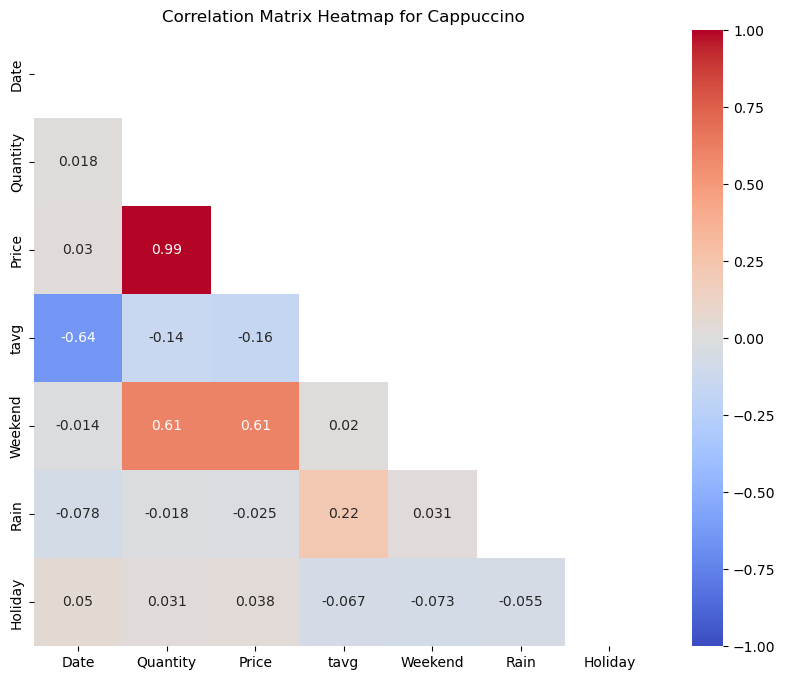

In [10]:
categories2=[category for category in categories if len(df_daily_dict[category])>100]

Corr_weekend={}
Corr_Rain={}
Corr_Holiday={}
Corr_temp={}

for category in categories2:

    coeff=df_daily_dict[category]['Quantity'].corr(df_daily_dict[category]['Weekend'])
    if coeff>0.20:
        Corr_weekend[category]=coeff
    coeff=df_daily_dict[category]['Quantity'].corr(df_daily_dict[category]['tavg'])
    if coeff>0.2:
        Corr_temp[category]=coeff
    coeff=df_daily_dict[category]['Quantity'].corr(df_daily_dict[category]['Rain'])
    if coeff>0.2:
        Corr_Rain[category]=coeff
    coeff=df_daily_dict[category]['Quantity'].corr(df_daily_dict[category]['Holiday'])
    if coeff>0.2:
        Corr_Holiday[category]=coeff

print("Rain correalation")
print(Corr_Rain)
print("Temperature correalation")
print(Corr_temp)
print("Holiday correlation")
print(Corr_Holiday)
print("Weekend correlation")
print(Corr_weekend)


def assign_zero(matrix, threshold):
    # Create a copy of the matrix to avoid modifying the original
    result = matrix.copy()
    # Assign 0 to elements smaller than the threshold
    result[result < threshold] = 0
    return result


item='Cappuccino'
corr_matrix = df_daily_dict[item].drop(columns=['Week']).corr()
#corr_matrix = assign_zero(df_hourly_dict[item].corr(),0.2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
plt.gcf().set_facecolor('none')
# Add title
plt.title(f'Correlation Matrix Heatmap for {item}')


### Identifying stationarity on Data

In [12]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, significance_level=0.05):
    # This returns a list with adf statistic (float), p-value (float), usedlag(int), nobs(int), critical values (dict),icbest(fl
    result = adfuller(series)
    # We take the p value
    p_value = result[1]
    # Returns true for stationary data
    return p_value < significance_level

# This function will differentiate the data until it is stationary (if the number of dif is smaller than 3)
def check_d_arima(series):
    n_dif=0
    stationarity = adf_test(series)
    while stationarity == False and n_dif<3:
        series_diff=series.diff().dropna()
        stationarity=adf_test(series_diff)
        n_dif=n_dif+1
    return n_dif

# Create a dictionary of itmes wih d paramter ARIMA(p,d,q) if the item has at least 100 data points
d={}
for category in categories:
    if len(df_daily_dict[category]) > 100:
        n=check_d_arima(df_daily_dict[category]['Quantity'])
        d[category]=n

{'Pane Frattau': 0, 'Cappuccino': 0, 'Lemon Ricotta Pancakes': 1, 'Tea': 1, 'San Pellegrino Water': 0, 'Open Food': 0, 'Avocado Toast': 0, 'Coffee Americano': 0, 'Latte': 0, 'Omelette': 0, 'Zucchini Fritters': 0, 'Spaghetti Cacio e Pepe': 0, 'Poached Eggs & Polenta': 0, 'Egg Panino': 0, 'Veggie Burger': 0, 'Bloody Mary - NY 1964 Edition': 0, 'Peroni': 0, 'Orange Juice': 0, 'Quinoa Salad': 0, 'Aperol Spritz': 0, 'Orecchiette con Radicchio e Pancetta': 0, 'Burrata': 0, 'Espresso': 0, 'Roasted Potatoes': 0, 'Garage Rose': 0, 'OMGimlet': 0, 'Gruner Veltliner. Bottle': 0, 'Homemade Chips': 0, 'Olives': 1, 'Polpettine di Vitello': 0, 'Renosu Bianco. Bottle': 0, 'Brussel sprouts': 0, 'Logical Hazy IPA': 0, 'Cotoletta alla Milanese': 0, 'Panino Milanese': 0, 'Pineapple juice': 0, 'Vegetarian Carbonara': 0, 'Coke': 0, 'Prosecco. Bottle': 0, 'Endive Salad': 0, 'E Rosato. Bottle': 0, 'Dinamo Litro Orange': 1, 'Pappardelle al Sugo di Carne': 0, 'Spaghetti Pesto': 0, 'Asparagus Salad': 1, 'Iced Tea

### Plots on stationarity

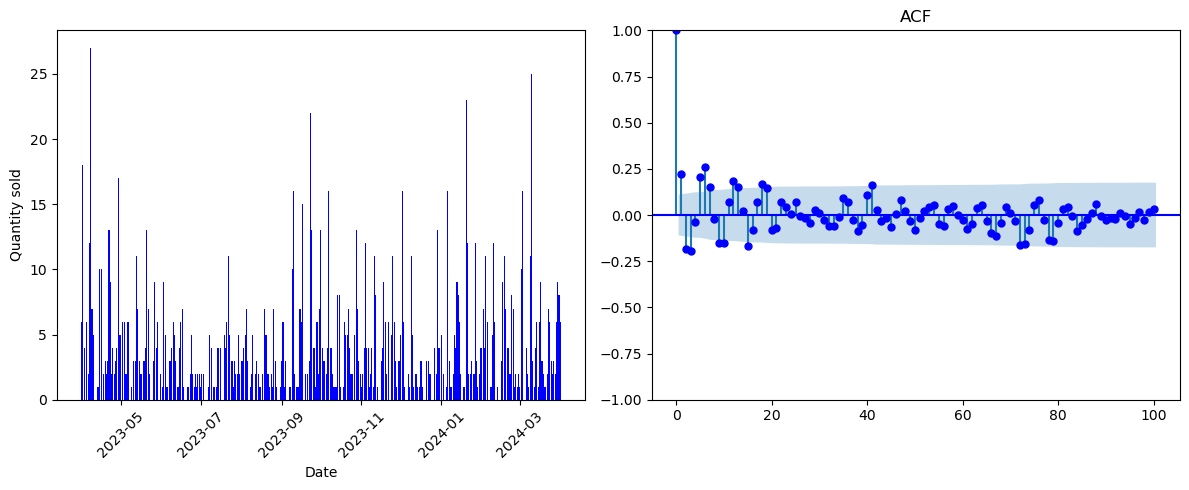

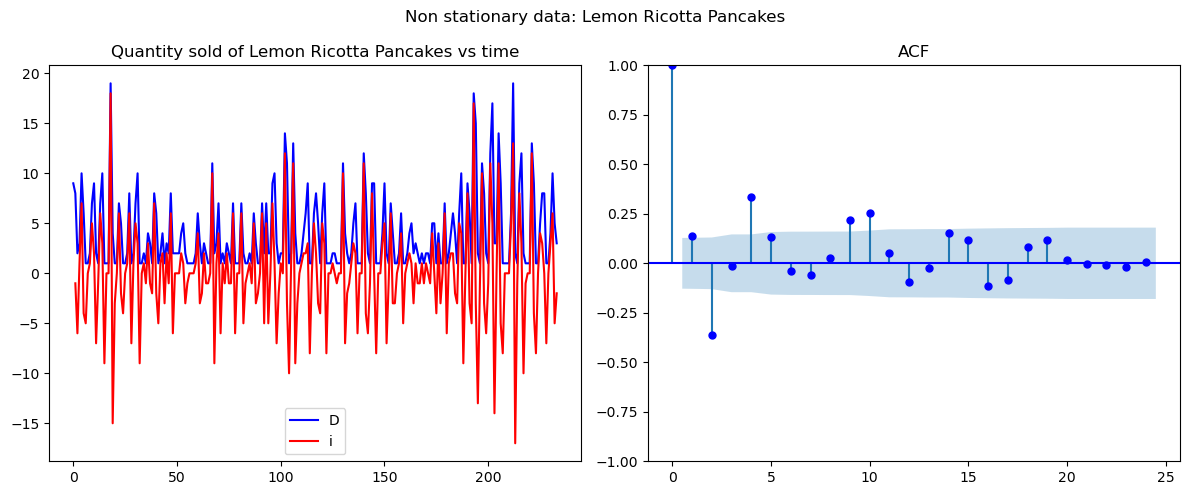

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

# For example Tiramisu is non-stationary (needs one diff) and omelette is stationary

name='Cappuccino'

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
#bins=bins = pd.date_range(start=df_hourly_dict[name]['Date'].min().floor('D'), end=df_hourly_dict[name]['Date'].max().ceil('D'), freq='D')
#axs[0].hist(df_hourly_dict[name]['Quantity'], bins=bins, alpha=0.7, color='blue')
axs[0].bar(df_daily_dict[name]['Date'], df_daily_dict[name]['Quantity'], color='Blue')
axs[0].set_ylabel('Quantity sold')
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_xlabel('Date')

# Plotting data on the second subplot
plot_acf(df_daily_dict[name]['Quantity'], ax=axs[1],color='blue',lags=100)
axs[1].set_title('ACF')

#plt.suptitle(f'Stationary data: {name}')
plt.tight_layout()
plt.gcf().set_facecolor('none')
plt.show()

name='Lemon Ricotta Pancakes'

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plt.title('Omelette')
axs[0].plot(df_daily_dict[name]['Quantity'], color='blue')
axs[0].legend('Data')
axs[0].plot(df_daily_dict[name]['Quantity'].diff().dropna(), color='red')
axs[0].legend('Differentiated Data')
axs[0].set_title(f'Quantity sold of {name} vs time')

# Plotting data on the second subplot
plot_acf(df_daily_dict[name]['Quantity'], ax=axs[1],color='blue')
#plot_acf(df_hourly_dict[name]['Quantity'].diff().dropna(), ax=axs[1],color='red')
axs[1].set_title('ACF')

plt.suptitle(f'Non stationary data: {name}')
plt.tight_layout()
plt.show()

### ARIMA tests

best ARIMA model (p,d,q) = ( 2, 1, 2 )
Average cv mase of 0.676
Predicted weekly sales of Pappardelle al Sugo di Carne =  9.142857142857142
Actual weekly sales of Pappardelle al Sugo di Carne =  7.204006107394164
Relative errror (%) 21.206183200376323
--------------------------------------------------------------


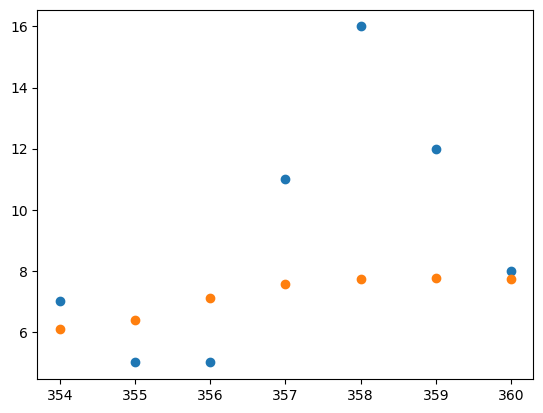

best ARIMA model (p,d,q) = ( 1, 1, 3 )
Average cv mase of 0.757
Predicted weekly sales of Tortelli di Zucca =  2.7142857142857144
Actual weekly sales of Tortelli di Zucca =  2.941429239720768
Relative errror (%) 8.368445673923025
--------------------------------------------------------------


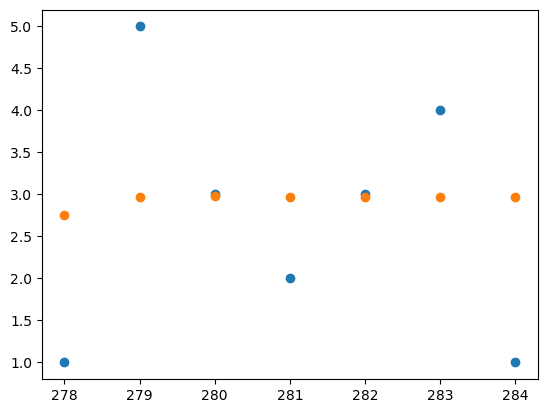

best ARIMA model (p,d,q) = ( 1, 1, 2 )
Average cv mase of 0.748
Predicted weekly sales of Spaghetti Pesto =  1.4285714285714286
Actual weekly sales of Spaghetti Pesto =  2.7550902504340447
Relative errror (%) 92.85631753038312
--------------------------------------------------------------


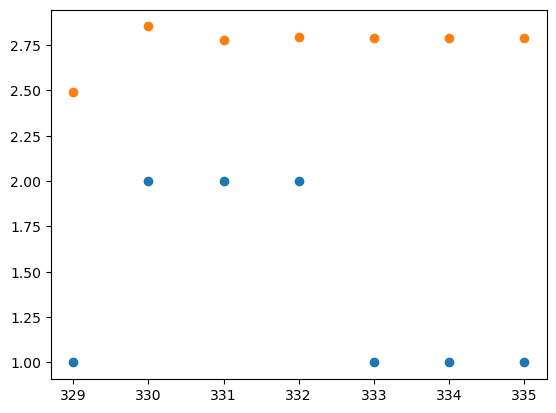

best ARIMA model (p,d,q) = ( 2, 1, 1 )
Average cv mase of 0.693
Predicted weekly sales of Gnocchi ai Funghi =  3.0
Actual weekly sales of Gnocchi ai Funghi =  3.84614170348298
Relative errror (%) 28.204723449432674
--------------------------------------------------------------


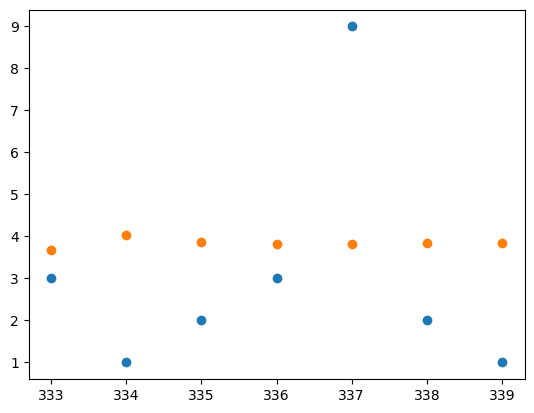

best ARIMA model (p,d,q) = ( 0, 1, 2 )
Average cv mase of 0.664
Predicted weekly sales of Omelette =  1.5714285714285714
Actual weekly sales of Omelette =  3.0572223285261884
Relative errror (%) 94.5505118153029
--------------------------------------------------------------


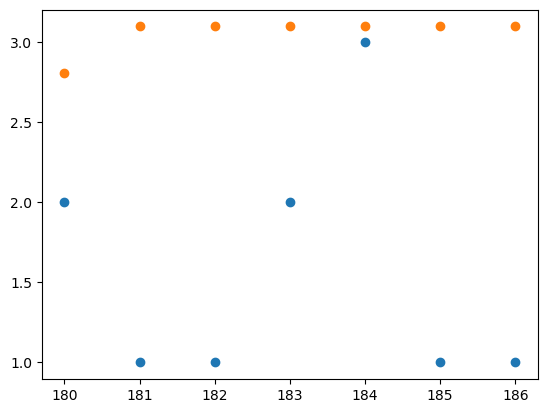

best ARIMA model (p,d,q) = ( 3, 1, 1 )
Average cv mase of 0.745
Predicted weekly sales of Aperol Spritz =  6.142857142857143
Actual weekly sales of Aperol Spritz =  4.45221189746903
Relative errror (%) 27.522131901666956
--------------------------------------------------------------


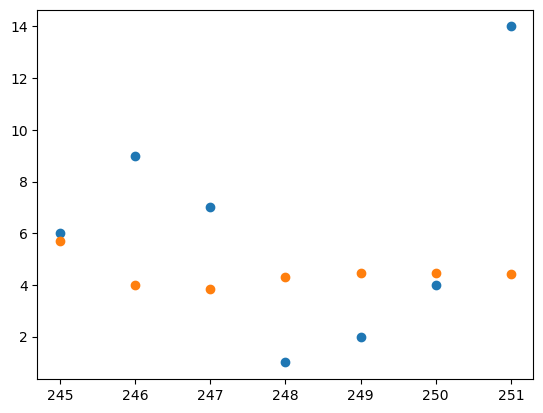

best ARIMA model (p,d,q) = ( 0, 1, 3 )
Average cv mase of 0.888
Predicted weekly sales of Latte =  6.142857142857143
Actual weekly sales of Latte =  5.642351037409056
Relative errror (%) 8.147773809620025
--------------------------------------------------------------


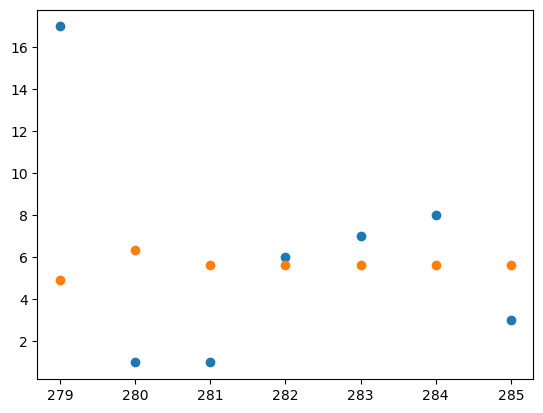

best ARIMA model (p,d,q) = ( 0, 1, 1 )
Average cv mase of 0.838
Predicted weekly sales of Panna Cotta =  2.0
Actual weekly sales of Panna Cotta =  1.7350001272863271
Relative errror (%) 13.249993635683644
--------------------------------------------------------------


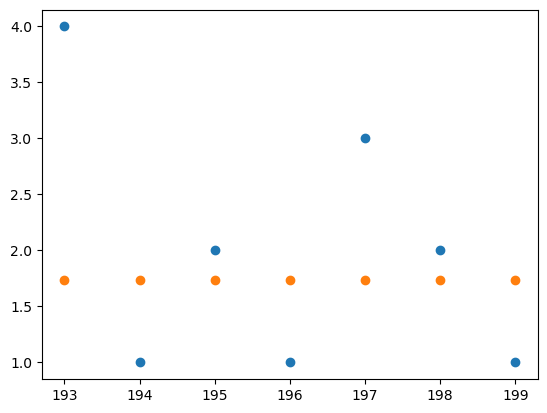

best ARIMA model (p,d,q) = ( 3, 1, 1 )
Average cv mase of 0.803
Predicted weekly sales of Coke =  4.714285714285714
Actual weekly sales of Coke =  2.349209646701232
Relative errror (%) 50.16828022148903
--------------------------------------------------------------


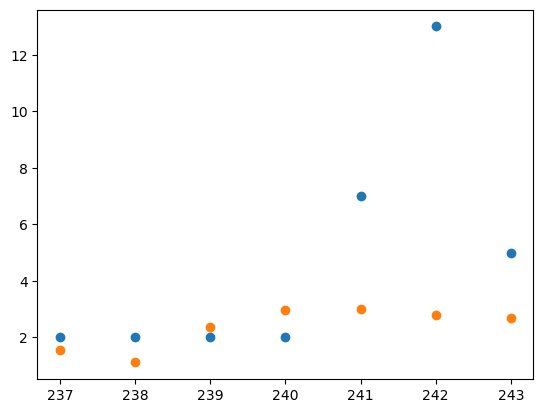

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import ARIMA

def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

total_values=[]
total_predictions=[]

# Selecting some items to try the model
probar=['Pappardelle al Sugo di Carne','Tortelli di Zucca','Spaghetti Pesto','Gnocchi ai Funghi','Omelette','Aperol Spritz','Latte','Panna Cotta','Coke']

n_range=4

for probar in probar:

    item_name=probar

    # last week worth of data aside for testing
    df_train = df_daily_dict[item_name].iloc[:-7].copy()
    df_test = df_daily_dict[item_name].drop(df_train.index).copy()


    cv=TimeSeriesSplit(n_splits=10,test_size=10)

    arima_mase=np.zeros((10,n_range,n_range))

    i=0
    for train_index, test_index in cv.split(df_train):
        df_tt=df_train.iloc[train_index]
        df_ho=df_train.iloc[test_index]

        j = 0
        for p in range(n_range):
            k = 0
            for q in range(n_range):
                #arima = ARIMA(df_tt['Quantity'].values,
                #                  order=(p, d['Aperol Spritz'], q)).fit()
                model=ARIMA(df_tt['Quantity'].values,
                                order=(p, d[item_name], q))
                #arima=model.fit(method='innovations_mle')
                arima=model.fit(method='innovations_mle')
                arima_mase[i,j,k] = mase(df_tt['Quantity'].values, df_ho['Quantity'].values,  arima.forecast(len(df_ho)))
                k = k +1
            j = j + 1
        i = i +1

    arima_ind = np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None),
                                np.mean(arima_mase, axis=0).shape)
    np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None),
                    np.mean(arima_mase, axis=0).shape)

    print("best ARIMA model",
            "(p,d,q) = ( %s, %s, %s )" %(range(n_range)[arima_ind[0]], 1, range(n_range)[arima_ind[1]]))

    print("Average cv mase of",
            np.round(np.mean(arima_mase, axis=0)[arima_ind],3))


    model=ARIMA(df_daily_dict[item_name]['Quantity'],order=(range(n_range)[arima_ind[0]], 1, range(n_range)[arima_ind[1]])).fit()

    steps=7
    forecast = model.get_forecast(steps=steps)
    forecast_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()
    forecast_index = np.arange(len(df_train), len(df_train) + steps)

    mean=df_test['Quantity'].mean()
    pred_mean=forecast_values.mean()

    total_predictions.append(mean)
    total_values.append(pred_mean)

    print(f'Predicted weekly sales of {item_name} = ', mean)
    print(f'Actual weekly sales of {item_name} = ', pred_mean)
    print('Relative errror (%)',np.abs(mean-pred_mean)/mean*100)
    print("--------------------------------------------------------------")
    plt.scatter(df_test.index,df_test['Quantity'])
    plt.scatter(df_test.index,forecast_values)
    plt.show()